In [1]:
import torch
from torch import nn
import torch.functional as F
from pipeline import *
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm_notebook

%load_ext autoreload
%autoreload 2

## Encoder for the model

### Summary
#### Architecture
1. Embedding Layer with the size of **(source_vocab_len, desired_embedding_size)**
2. Bidirectional GRU unit with size **(desires_embedding_size, desired_hidden_layer_size)**






In [2]:
class NMTEncoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        super(NMTEncoder, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.gru = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True, batch_first=True)
        
        
    def forward(self,x, x_len):
        embedded = self.embedding(x)
        # Create packed sequence
        x_len = x_len.detach().cpu().numpy()
        x_packed = pack_padded_sequence(embedded, x_len, batch_first=True)
        
        # x_birnn_h.shape = (num_rnn, batch_size, feature_size)
        x_birnn_out, x_birnn_h = self.gru(x_packed)
        # permute to (batchs, num_rnn, feature_size)
        x_birnn_h = x_birnn_h.permute(1, 0, 2)
        
        #flatten (bz, rnn_hid * feat_size)
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0),-1)
        
        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first = True)
        return x_unpacked, x_birnn_h
        
        

In [3]:
class NMTDecoder(nn.Module):
    """
     Args:
        num_embeddings (int): number of embeddings; also the number of unique words in the target vocabulary
        embedding_size (int): size of the embedding vector 
        rnn_hidden_size (int): size of the hidden RNN state bos_index(int): BEGIN-OF-SEQUENCE index
    """
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        super(NMTDecoder, self).__init__()
        
        self._rnn_hidden_size = rnn_hidden_size
        
        self.t_embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, rnn_hidden_size)
        
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        
        self.classifier = nn.Linear(rnn_hidden_size * 2,num_embeddings)
        self.bos_index = bos_index
        self._sampling_temperature = 3
        
        
    def _init_indices(self, batch_size):
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    
    def _init_context_vectors(self, batch_size):
        return torch.zeros(batch_size, self._rnn_hidden_size)
    
    def forward(self, encoder_state, initial_hidden_state, target_seq, sample_probability=0.0):
        """The forward pass of the model
        Args:
            encoder_state (torch.Tensor): output of the NMTEncoder 
            initial_hidden_state (torch.Tensor): last hidden state in the NMTEn 
            target_sequence (torch.Tensor): target text data tensor 
            sample_probability (float): schedule sampling parameter
            probability of using model's predictions at each decoder step 
        Returns:
            output_vectors (torch.Tensor): prediction vectors at each output st
        """
        
        if target_seq is None: 
            sample_probability = 1.0
        else:
            # The input is (batch, Seq)
            # We iterate and permute to (S, B)
            target_seq = target_seq.permute(1,0)
            output_sequence_size = target_seq.size(0)
        
        #target_seq = target_seq.permute(1,0)
        
        batch_size = encoder_state.size(0)
        
        h_t = self.hidden_map(initial_hidden_state)
        
        context_vectors = self._init_context_vectors(batch_size)
        
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        
        context_vectors = context_vectors.to(encoder_state.device)
        
        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        output_sequence_size = target_seq.size(0)
        # iterate through each output of encoder rnn
        for i in range(output_sequence_size):
            use_sample = np.random.random() < sample_probability
            
            if not use_sample:
                
                y_t_index = target_seq[i]
            
            # Step 1: Embed word and concat with previous context
            y_input_vector = self.t_embedding(y_t_index)
            
            rnn_input = torch.cat([y_input_vector, context_vectors],dim=1)

            # Step 2: Make a GRU step, getting a new hidden vector
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t)

            # Step 3: Use current hidden vector to attend to atten encoder state
            context_vectors, p_attn, _ = verbose_attention(encoder_state = encoder_state, 
                                                          query=h_t)

            # auxillary: cache the attention probabilities for vis
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())

            # Step 4: use current context vector and hidden state for prediction
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(prediction_vector)
            if use_sample:
                # sampling temperature forces a peakier distribution
                p_y_t_index = F.softmax(score_for_y_t_index * self._sampling_temperature, dim=1)
                # choose most likely word
                _, y_t_index = torch.max(p_y_t_index,1)
                # sample from dist
                y_t_index = torch.multinomial(p_y_t_index, 1).squeeze()
            
            output_vectors.append(score_for_y_t_index)
            
            
        output_vectors = torch.stack(output_vectors).permute(1,0,2)
        return output_vectors
        
        
        
        
        
        

In [4]:
def verbose_attention(encoder_state,query):
    batch_size, num_vectors, vector_size = encoder_state.size()
    
    vector_scores = torch.sum(encoder_state * query.view(batch_size,1,vector_size), dim=2)
    probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = encoder_state * probabilities.view(batch_size,num_vectors , 1)
    context_vectors = torch.sum(weighted_vectors,dim=1)
    return context_vectors, probabilities, vector_scores


def terse_attention(encoder_state, query):
    """A shorter and more optimized version of the neural attention mechanism
    
    Args:
        encoder_state_vectors (torch.Tensor): 3dim tensor from bi-GRU in encoder
        query_vector (torch.Tensor): hidden state
    """
    
    torch_scores = torch.matmul(encoder_state, query.unsqueeze(dim=2)).squeeze()
    probabilities = F.softmax(torch_scores)
    context_vectors = torch.matmul(encoder_state.transpose(-2,-1), probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, probabilities

In [5]:
class NMTModel(nn.Module):
    """ A Neural Translation Model"""
    def __init__(self, source_vocab_size, source_embedding_size, target_vocab_size, target_embedding_size, 
                encoding_size, target_bos_index):
        
        """
        Args:
            source_vocab_size (int): number of unique words in source vocabulary
            source_embedding_size (int): size of embedding vector
            target_vocab_size(int): number of unique words in target vocabulary
            target_embeddiing_size (int): size of target embedding vector
            encoding_size (int): size of encoder RNN
            target_bos_index (int): index for BEGIN-OF-SEQUENCE token
        """
        
        super(NMTModel,self).__init__()
        self.encoder = NMTEncoder(num_embeddings=source_vocab_size,
                                 embedding_size=source_embedding_size,
                                 rnn_hidden_size = encoding_size)
        decoding_size = encoding_size * 2
        self.decoder = NMTDecoder(num_embeddings=target_vocab_size,
                                 embedding_size=target_embedding_size,
                                 rnn_hidden_size=decoding_size,
                                 bos_index=target_bos_index)
        
    def forward(self, x_source, x_source_lengths, target_sequence):
        """The forward pass of the model
        
        Args:
            x_source (torch.Tensor): the source text data tensor. 
                x_source.shape should be (batch, vectorizer.max_source_length)
            x_source_lengths torch.Tensor): the length of the sequences in x_source 
            target_sequence (torch.Tensor): the target text data tensor
        Returns:
            decoded_states (torch.Tensor): prediction vectors at each output step
        """
        encoder_state, hidden_state = self.encoder(x_source, x_source_lengths)
        decoder_out = self.decoder(encoder_state, hidden_state, target_sequence)
        
        return decoder_out

## Training utility functions

In [6]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.
    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """Normalize tensor sizes
    
    Args:
        y_pred (torch.Tensor): the output of the model
            If a 3-dimensional tensor, reshapes to a matrix
        y_true (torch.Tensor): the target predictions
            If a matrix, reshapes to be a vector
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [7]:
args = Namespace(dataset_csv="data/simplest_eng_fra.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model.pth",
                 save_dir="model_storage/",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=False,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=64,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=64, 
                 target_embedding_size=64,
                 encoding_size=64,
                 catch_keyboard_interrupt=True)

In [8]:
import os
if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/vectorizer.json
	model_storage/model.pth
Using CUDA: False


In [9]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = NMTDataset.load_dataset_and_load_vectorizer(args.dataset_csv, args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

In [10]:
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("Reloaded model")
else:
    print("New model")

Reloaded model


In [217]:

model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        
        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset,batch_size=args.batch_size,device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()
     
            y_pred = model(batch_dict['x_source'], batch_dict['x_source_length'], batch_dict['x_target'])
            
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            
            train_bar.update()
            
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        
        # iterate over val set
        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset, batch_size=args.batch_size,device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.eval()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            
            
            y_pred = model(batch_dict['x_source'], batch_dict['x_source_length'], batch_dict['x_target'])
            
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            
            val_bar.update()
        
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        
        train_state = update_train_state(args=args, model=model, train_state=train_state)
        scheduler.step(train_state['val_loss'][-1])
        
        if train_state['stop_early']:
            break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'])
        epoch_bar.update()
        
except KeyboardInterrupt:
    print('Exit')

C:\Users\kaanb\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


C:\Users\kaanb\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\kaanb\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [11]:
model.load_state_dict(torch.load('model_storage/model.pth'))
model.eval()

NMTModel(
  (encoder): NMTEncoder(
    (embedding): Embedding(3025, 64, padding_idx=0)
    (gru): GRU(64, 64, batch_first=True, bidirectional=True)
  )
  (decoder): NMTDecoder(
    (t_embedding): Embedding(4911, 64, padding_idx=0)
    (gru_cell): GRUCell(192, 128)
    (hidden_map): Linear(in_features=128, out_features=128, bias=True)
    (classifier): Linear(in_features=256, out_features=4911, bias=True)
  )
)

In [13]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
sf = bleu_score.SmoothingFunction()

In [21]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
            
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
        
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'], x_source_lengths=batch_dict['x_source_length'],
                           target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)
    
    
    def get_ith_item(self, index, return_string=True):
        output = {'source': self._get_source_sentence(index, return_string=return_string),
                 'reference':self._get_reference_sentence(index, return_string=return_string),
                 'sampled': self._get_sampled_sentence(index, return_string=return_string),
                 'attention': self._last_batch['attention'][index]
                 }
        
        reference = output['reference']
        hypothesis = output['sampled']
        if not return_string:
            reference =  " ".join(reference)
            hypothesis = " ".join(hypothesis)
            
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference], hypothesis=hypothesis,
                                                   smoothing_function=sf.method1)
        
        return output
        

In [22]:
model = model.eval().to(args.device)

sampler = NMTSampler(vectorizer,model)

dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size,
                                       device=args.device)

test_results = []

for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i,False))

(array([18., 18., 21., 17., 10., 15., 15., 12.,  9., 27., 28., 24., 32.,
        28., 27., 39., 31., 41., 43., 43., 50., 45., 55., 57., 46., 52.,
        60., 64., 48., 59., 54., 44., 50., 51., 55., 46., 27., 48., 60.,
        42., 39., 46., 51., 45., 38., 58., 30., 16.,  1., 85.]),
 array([0.01513086, 0.03482824, 0.05452562, 0.074223  , 0.09392039,
        0.11361777, 0.13331515, 0.15301254, 0.17270992, 0.1924073 ,
        0.21210468, 0.23180207, 0.25149945, 0.27119683, 0.29089422,
        0.3105916 , 0.33028898, 0.34998637, 0.36968375, 0.38938113,
        0.40907851, 0.4287759 , 0.44847328, 0.46817066, 0.48786805,
        0.50756543, 0.52726281, 0.54696019, 0.56665758, 0.58635496,
        0.60605234, 0.62574973, 0.64544711, 0.66514449, 0.68484187,
        0.70453926, 0.72423664, 0.74393402, 0.76363141, 0.78332879,
        0.80302617, 0.82272355, 0.84242094, 0.86211832, 0.8818157 ,
        0.90151309, 0.92121047, 0.94090785, 0.96060523, 0.98030262,
        1.        ]),
 <a list of 50

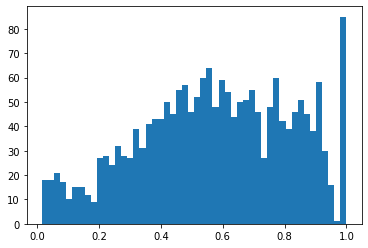

In [23]:
plt.hist([r['bleu-4'] for r in test_results], bins=50)

In [ ]:
for sample in top_results:
    plt.figure()
    target